In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Import relevant components

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

### Data Preparation
1. Read data from a csv file and convert it into a timeseries

Data Format : 
            Average of Discharge
Time                            
1981-01-01              0.796129
1981-02-01              0.268571
1981-03-01              0.105484
1981-04-01              0.014000
1981-05-01              0.730968


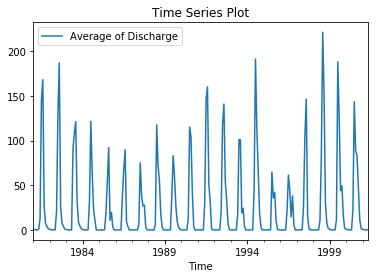

In [3]:
def dateparse(year, month):
    date = year + "-" + month
    return pd.datetime.strptime(date, '%Y-%m')

data = pd.read_csv('River_Flow.csv', parse_dates= {'Time': ['Year', 'Month']}, index_col= 0, date_parser=dateparse) #parse columns Year, Month as date and call result as Time

print("Data Format : \n{}".format(data.head()))
data.plot()
plt.title('Time Series Plot')
plt.show()

### Examine Stationarity
Three ways used to examine stationarity:
1. Look at plots - Time plot, ACF/PACF plots
2. Summary statistics - Significant difference in summary statistics in 2 intervals of data
3. Dickey-Fuller Test

In [4]:
def calculate_acf(timeseries, lag = 40):
    acf = np.zeros((lag + 1, 2))
    len_ = timeseries.shape[0]
    significant = 1.96/np.sqrt(len_)
    X = timeseries.iloc[:, 0].values
    denominator = np.dot(X - X.mean(), X - X.mean())
    for i in range(lag + 1):
        numerator = np.dot(timeseries.iloc[i:len_, 0].values - X.mean(),timeseries.shift(i).iloc[i:len_, 0].values - X.mean())
        acf[i] = [i, numerator/denominator]
    plt.xlabel("Lags")
    plt.ylabel("Autocorrelation")
    plt.title("ACF")
    plt.bar(acf[:,0], acf[:,1], width = 0.2);
    plt.axhline(y=0)
    plt.axhline(y=significant, color = 'k', linestyle='--')
    plt.axhline(y=-significant, color = 'k', linestyle='--')
    plt.show()


def calculate_pacf(timeseries, lag = 40):
    pacf = np.zeros((lag + 1, 2))
    len_ = timeseries.shape[0]
    significant = 1.96 / np.sqrt(len_)
    for i in range(lag + 1):
        if i == 0:
            pacf[i] = [i,1]
        else:
            X, Y = autoregression_coefficients(timeseries, i)
            pacf[i] = [i, X[-1]]
    plt.xlabel("Lags")
    plt.ylabel("Partial Autocorrelation")
    plt.title("PACF")
    plt.bar(pacf[:, 0], pacf[:, 1], width=0.2)
    plt.axhline(y=0)
    plt.axhline(y=significant, color='k', linestyle='--')
    plt.axhline(y=-significant, color='k', linestyle='--')
    plt.show()


def summary_statistics(timeseries):
    X = timeseries.iloc[:, 0].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print("\nSummary Statistics:")
    print('Mean1=%f, Mean2=%f' % (mean1, mean2))
    print('Variance1=%f, Variance2=%f' % (var1, var2))


def test_stationarity(timeseries):
    X = timeseries.iloc[:,0].values
    result = adfuller(X)
    print('\nResults of Dickey-Fuller Test:')
    print('Test Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %f' % (key, value))
    if result[1] < 0.05:
        print("\nTime series is stationary")
    else:
        print("\nTime series is non-stationary. Data transformation is required")

### Remove Non-stationarity
1. Stationarity in variance - Transform data (log/sqrt transform)
2. Stationarity in mean - First/Second differencing
3. Remove seasonality - Seasonal differencing (do it before first/second differencing)

In [5]:
def log_transform(timeseries):
    Y = timeseries.copy()
    X = Y.iloc[:, 0].values
    Y.iloc[:, 0] = np.log(X+1)
    return Y


def diff(timeseries, diff_order):
    diff = timeseries - timeseries.shift(diff_order)
    diff = diff.dropna()
    return diff

### Model Identification
1. AR(p) - PACF is non-significant beyond lag p. ACF plot shows exponential/damped sine decay
2. MA(q) - ACF is non-significant beyond lag q. PACF plot shows exponential/damped sine decay

In [6]:
def model_identification(timeseries):
    p = input("\nEnter value for p in AR model: ")
    print("Model chosen is : AR({})".format(p))
    return p

### Parameter Estimation
1. Do Autoregression
$Y(t) = b_0 + b_1*Y(t-1) + b_2*Y(t-2) +...+ b_k*Y(t-k)$
2. Get coefficients $(b_0, b_1, b_2,..,b_k)$

In [7]:
def autoregression_coefficients(timeseries, lag):
    len_ = timeseries.shape[0]
    X = np.zeros((len_, lag+1))
    for i in range(lag+1):
        if i == 0:
            X[:, i] = 1
        else:
            X[:, i] = timeseries.shift(i).iloc[:len_, 0].values
    X = X[lag:len_]
    Y = timeseries.iloc[lag:len_, 0].values
    coefficients = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))
    y_estimated = np.dot(X, coefficients)
    Y_estimated = pd.DataFrame({'Estimated Value':y_estimated}).set_index(keys = timeseries.index[lag:len_])
    return coefficients, Y_estimated

### Forecasting
Do forecasting in stationary series and then convert to original series.

$Y(t+1) = b_0 + b_1*Y(t) + b_2*Y(t-1) +...+ b_k*Y(t-k+1)$

In [8]:
def forecast(stationary_estimated, original_estimated, coefficients, num_predictions, lag=None, seasonality=None):
    for i in range(num_predictions):
        X = np.append([1], stationary_estimated.iloc[-lag:, 0])
        Y = original_estimated.iloc[-seasonality, 0]
        Z_hat = np.dot(X.T, coefficients)
        Y_hat = np.exp(Z_hat + np.log(Y))
        forecasted_month = stationary_estimated.index[-1] + pd.DateOffset(months=1)
        W = pd.DataFrame({'Estimated Value': Z_hat}, index = [forecasted_month])
        stationary_estimated = stationary_estimated.append(W)
        Q = pd.DataFrame({'Estimated Value': Y_hat}, index=[forecasted_month])
        original_estimated = original_estimated.append(Q)

    return original_estimated

### Main Function
1. Plots original time series 
2. Plots ACF and PACF for both non-stationary and stationary time series 
3. Fits AR(p) model along with forecasted values

In [9]:
def main():
    #test stationarity of given data
    calculate_acf(data)
    calculate_pacf(data)
    summary_statistics(data)
    test_stationarity(data)

    #transform data
    num_predictions = 12
    diff_order = 12
    transformed_data = log_transform(data)
    seasdiff= diff(transformed_data, diff_order)

    #test stationarity of transformed data
    calculate_acf(seasdiff)
    calculate_pacf(seasdiff)
    summary_statistics(seasdiff)
    test_stationarity(seasdiff)

    #fit model
    lag=int(model_identification(seasdiff))
    coefficients, stationary_estimated = autoregression_coefficients(seasdiff, lag)
    shifted_data = transformed_data.shift(diff_order)
    original_estimated_ = np.exp(stationary_estimated.iloc[:, 0] + shifted_data.iloc[diff_order+lag:shifted_data.shape[0], 0])
    original_estimated = pd.DataFrame({'Estimated Value':original_estimated_}, index = stationary_estimated.index)

    #forecast
    extended_series = forecast(stationary_estimated, original_estimated, coefficients, num_predictions, lag, diff_order)
    length = extended_series.shape[0]

    #plot data
    plt.plot(data)
    plt.plot(extended_series.iloc[:, 0])
    plt.plot(extended_series.iloc[length-num_predictions:, 0])
    plt.xlabel('Time')
    plt.ylabel('Average Discharge')
    plt.legend(['original', 'estimated', 'forecasted'], loc='lower right')
    plt.title('AR({}) Model'.format(lag))
    plt.show()

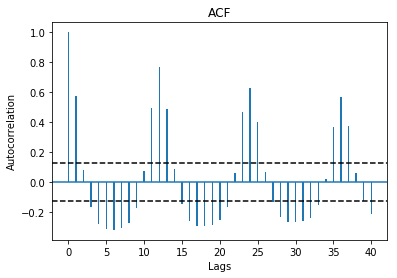

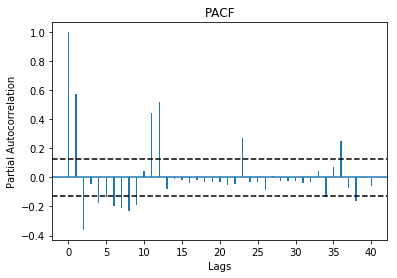


Summary Statistics:
Mean1=22.182388, Mean2=28.176477
Variance1=1595.795469, Variance2=2366.178346

Results of Dickey-Fuller Test:
Test Statistic: -2.278093
p-value: 0.179131
Critical Values:
	1%: -3.458731
	5%: -2.874026
	10%: -2.573424

Time series is non-stationary. Data transformation is required


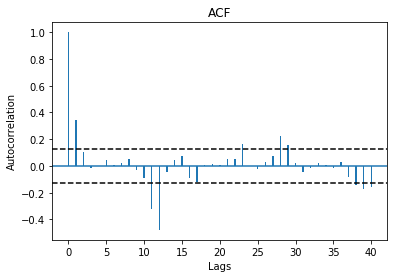

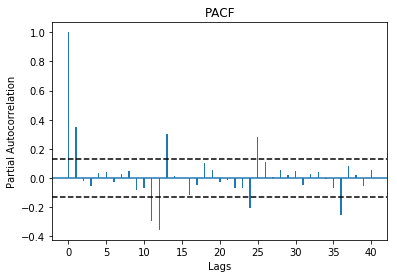


Summary Statistics:
Mean1=-0.027685, Mean2=0.055082
Variance1=0.328535, Variance2=0.674325

Results of Dickey-Fuller Test:
Test Statistic: -5.207111
p-value: 0.000009
Critical Values:
	1%: -3.460428
	5%: -2.874769
	10%: -2.573821

Time series is stationary

Enter value for p in AR model: 1
Model chosen is : AR(1)


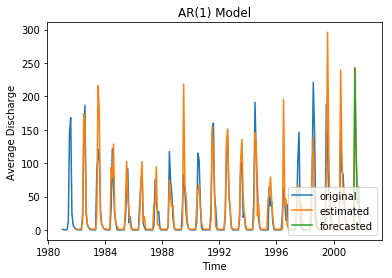

In [11]:
main()

Main() function could be called multiple times to check for various values of p.